In [1]:
!pip install tensorflow numpy matplotlib opencv-python Pillow

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL.Image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

In [3]:
# Function to load and process an image
def load_and_process_image(image_path):
    img=PIL.Image.open(image_path).convert('RGB')
    img=img.resize((224,224))
    img=np.array(img, dtype=np.float32)
    img=np.expand_dims(img,axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img)


In [4]:
# Function to deprocess an image
def deprocess_image(img):
    img=img.reshape((224,224,3))
    img[:,:,0]+=103.939
    img[:,:,1]+=116.779
    img[:,:,2]+=123.68
    img=np.clip(img,0,255).astype('uint8')
    return img

In [7]:
from google.colab import files
uploaded=files.upload()

Saving wallpaper.png to wallpaper.png


In [8]:
# load images
content_image=load_and_process_image('wallpaper.png')
style_image=load_and_process_image('img.png')

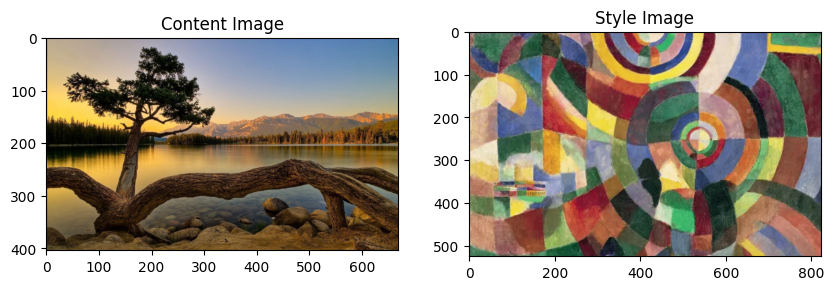

In [9]:
# Display images
def display_images(content_image,style_image):
    fig,axes=plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(np.array(PIL.Image.open("wallpaper.png")))
    axes[0].set_title('Content Image')
    axes[1].imshow(np.array(PIL.Image.open("img.png")))
    axes[1].set_title('Style Image')
    plt.show()

display_images(content_image,style_image)

In [10]:
# Extract intermediate layers
def get_model():
    # load VGG19 model
    vgg=VGG19(weights='imagenet',include_top=False)
    vgg.trainable=False
    content_layers=['block5_conv2']
    style_layers=[
        'block1_conv1',
        'block2_conv1',
        'block3_conv1',
        'block4_conv1',
        'block5_conv1'
    ]
    model_outputs=[vgg.get_layer(layer).output for layer in (style_layers+content_layers)]
    return Model(inputs=vgg.input,outputs=model_outputs),style_layers,content_layers

In [11]:
#compute gram matrix for style loss
def gram_matrix(input_tensor):
    channels=int(input_tensor.shape[-1])
    a=tf.reshape(input_tensor,[-1,channels])
    n=tf.shape(a)[0]
    gram=tf.matmul(a,a,transpose_a=True)
    return gram/tf.cast(n,tf.float32)

In [12]:
# compute loss
def compute_loss(model,loss_weights,init_image,gram_style_features,content_features):
    style_weight,content_weight=loss_weights
    model_outputs=model(init_image)
    style_output_features=model_outputs[:len(gram_style_features)]
    content_output_features=model_outputs[len(gram_style_features):]

    style_loss=tf.add_n([tf.reduce_mean((gram_matrix(style_output_features[i])-gram_style_features[i])**2)for i in range(len(style_output_features))])
    style_loss*=style_weight/len(style_output_features)

    content_loss=tf.add_n([tf.reduce_mean((content_output_features[i]-content_features[i])**2)for i in range(len(content_output_features))])
    content_loss*=content_weight/len(content_output_features)

    total_loss=style_loss + content_loss
    return total_loss

In [13]:
# perform optimization
def style_transfer(content_path,style_path, num_iterations=1000,content_weight=1e3,style_weight=1e-2):
    model,style_layers,content_layers=get_model()

    style_features=model(load_and_process_image(style_path))[:5]
    content_features=model(load_and_process_image(content_path))[5:]

    style_features=model(style_image)[:5]
    content_features=model(content_image)[5:]

    gram_style_features=[gram_matrix(feature) for feature in style_features]
    init_image=tf.Variable(content_image, dtype=tf.float32)
    loss_weights=(style_weight,content_weight)
    # optimizer
    optimizer=tf.optimizers.Adam(learning_rate=5.0)

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
         loss=compute_loss(model,loss_weights,init_image,gram_style_features,content_features)
        grad=tape.gradient(loss,init_image)
        optimizer.apply_gradients([(grad,init_image)])

        init_image.assign(tf.clip_by_value(init_image,-150,150))

        if i %100==0:
           print(f"iteration{i}:loss{loss.numpy()}")

    return deprocess_image(init_image.numpy())


In [14]:
# Run the style transfer
output_image=style_transfer('wallpaper.png','img.png')

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
iteration0:loss388108768.0
iteration100:loss5692911.5
iteration200:loss4052133.25
iteration300:loss3524572.25
iteration400:loss4625025.0
iteration500:loss3268427.5
iteration600:loss3149454.5
iteration700:loss3150945.0
iteration800:loss4154405.0
iteration900:loss3296712.0


In [15]:
# Display the final image

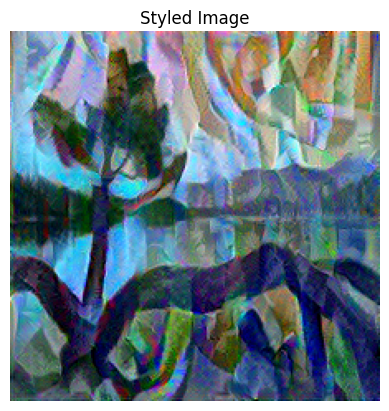

In [16]:
plt.imshow(output_image)
plt.axis("off")
plt.title("Styled Image")
plt.show()

In [17]:
# Save the final image
output_image_pil=PIL.Image.fromarray(output_image)
output_image_pil.save("output_image.jpg")